In [ ]:
# import clear out to clear output during library installation
from IPython.display import clear_output
!pip install transformers datasets torch scikit-learn seaborn

In [1]:
import torch
import numpy as np
from datasets import load_dataset
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))


Using device: cuda
GPU: NVIDIA L4


# The IMDb movie reviews dataset is used for this study. It consists of 50,000 English-language movie reviews evenly split between positive and negative sentiment labels. The dataset is pre-divided into training and testing subsets.


In [2]:
dataset = load_dataset("imdb")

dataset


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

This cell extracts a small set of example reviews from the training dataset for demonstration purposes. It collects three positive and three negative reviews based on their sentiment labels. For each selected review, the code displays the dataset index, sentiment label, and a truncated version of the review text (up to 600 characters) to provide a quick preview of the content. This helps in understanding the type of data and the sentiment distribution in the dataset before further processing.

In [ ]:
positive_reviews = []
negative_reviews = []

# Collect 3 unique reviews per class
for idx, review in enumerate(dataset["train"]):
    if review["label"] == 1 and len(positive_reviews) < 3:
        positive_reviews.append((idx, review["text"], review["label"]))
    elif review["label"] == 0 and len(negative_reviews) < 3:
        negative_reviews.append((idx, review["text"], review["label"]))

    if len(positive_reviews) == 3 and len(negative_reviews) == 3:
        break

# Display positive reviews
print("POSITIVE REVIEWS")
print("=" * 90)
for i, (idx, text, label) in enumerate(positive_reviews, 1):
    print(f"Positive Review {i}")
    print(f"Dataset Index: {idx}")
    print(f"Sentiment Label: {label} (Positive)")
    print(text[:600])
    print("-" * 90)

# Display negative reviews
print("\nNEGATIVE REVIEWS")
print("=" * 90)
for i, (idx, text, label) in enumerate(negative_reviews, 1):
    print(f"Negative Review {i}")
    print(f"Dataset Index: {idx}")
    print(f"Sentiment Label: {label} (Negative)")
    print(text[:600])
    print("-" * 90)



POSITIVE REVIEWS
Positive Review 1
Dataset Index: 12500
Sentiment Label: 1 (Positive)
Zentropa has much in common with The Third Man, another noir-like film set among the rubble of postwar Europe. Like TTM, there is much inventive camera work. There is an innocent American who gets emotionally involved with a woman he doesn't really understand, and whose naivety is all the more striking in contrast with the natives.<br /><br />But I'd have to say that The Third Man has a more well-crafted storyline. Zentropa is a bit disjointed in this respect. Perhaps this is intentional: it is presented as a dream/nightmare, and making it too coherent would spoil the effect. <br /><br />This 
------------------------------------------------------------------------------------------
Positive Review 2
Dataset Index: 12501
Sentiment Label: 1 (Positive)
Zentropa is the most original movie I've seen in years. If you like unique thrillers that are influenced by film noir, then this is just the right cure f

This cell visualizes the distribution of sentiment labels in the IMDb training dataset. It counts the number of positive and negative reviews, then creates a bar chart to show how many reviews belong to each class. The chart also displays the exact count above each bar for clarity, helping to quickly understand the dataset’s class balance.

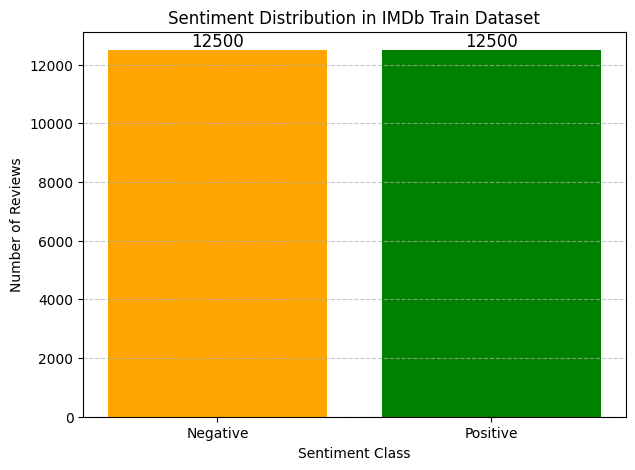

In [4]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_sentiment_distribution(dataset, split="train"):
    """
    Plots the sentiment distribution of the IMDb dataset.

    Parameters:
    -----------
    dataset : dict
        Dictionary containing 'train' or 'test' splits with 'label' keys.
    split : str
        Dataset split to visualize ('train' or 'test').
    """
    # Count sentiment labels
    label_counts = Counter(dataset[split]["label"])

    # Map labels to human-readable sentiment classes
    sentiments = ["Negative", "Positive"]
    counts = [label_counts.get(0, 0), label_counts.get(1, 0)]

    # Plot bar chart with new colors
    plt.figure(figsize=(7,5))
    bars = plt.bar(sentiments, counts, color=["orange", "green"])

    # Add value labels on top of each bar
    for i, count in enumerate(counts):
        plt.text(i, count + max(counts)*0.01, str(count), ha="center", fontsize=12)

    # Axis labels and title
    plt.xlabel("Sentiment Class")
    plt.ylabel("Number of Reviews")
    plt.title(f"Sentiment Distribution in IMDb {split.capitalize()} Dataset")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

# Function call
plot_sentiment_distribution(dataset, split="train")



# Methodology: Tokenisation & Preprocessing

In this step, I implement the tokenisation and preprocessing pipeline for the IMDb dataset. Using BERT tokenizer, each review is converted into token IDs with consistent length through padding and truncation. The processed dataset is converted to PyTorch format for training, ensuring reproducibility and easy integration with HuggingFace Trainer.

In [5]:
# This cell implements the preprocessing and tokenization of IMDb reviews for BERT input.
# The BERT tokenizer converts text into token IDs with padding and truncation.
# This is implemented as a reusable function to allow the same preprocessing for train/test datasets.

from transformers import BertTokenizer
from datasets import load_dataset

# Load IMDb dataset
dataset = load_dataset("imdb")

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def preprocess_dataset(dataset, tokenizer, max_len=256):
    """
    Tokenizes IMDb reviews for BERT input.

    Parameters:
    -----------
    dataset : DatasetDict
        IMDb dataset containing 'train' and 'test' splits
    tokenizer : BertTokenizer
        Pre-trained BERT tokenizer
    max_len : int
        Maximum sequence length for padding/truncation

    Returns:
    --------
    tokenized_datasets : DatasetDict
        Tokenized and PyTorch-ready dataset
    """
    def tokenize(batch):
        return tokenizer(
            batch["text"],
            padding="max_length",
            truncation=True,
            max_length=max_len
        )

    tokenized = dataset.map(tokenize, batched=True)
    tokenized = tokenized.remove_columns(["text"])
    tokenized = tokenized.rename_column("label", "labels")
    tokenized.set_format("torch")

    return tokenized

# Preprocess dataset
tokenized_datasets = preprocess_dataset(dataset, tokenizer)
tokenized_datasets


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})

This step initializes the BERT model for sentiment classification. A compute_metrics function is defined to evaluate model performance using accuracy, precision, recall, and F1-score during training and validation.

In [6]:
# This cell initializes BERT for sequence classification and defines evaluation metrics.

from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

# Initialize BERT model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2  # Binary sentiment classification: Negative/Positive
)

# Evaluation metric function
def compute_metrics(pred):
    """
    Computes accuracy, precision, recall, and F1-score.
    """
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Here, define the training configuration, including batch size, learning rate, number of epochs, and evaluation strategy. HuggingFace Trainer is initialized to manage training, evaluation, and checkpoint saving automatically.

In [7]:
# Set training hyperparameters and initialize Trainer

training_args = TrainingArguments(
    output_dir="./bert_imdb",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


/tmp/ipython-input-1809851748.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [8]:
# Train the model
trainer.train()


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.241900,0.243260,0.907360,0.952461,0.857520,0.902501
2,0.156100,0.266393,0.921960,0.930326,0.912240,0.921194
3,0.094300,0.368773,0.918960,0.899222,0.943680,0.920915
4,0.043500,0.418115,0.921680,0.909366,0.936720,0.922840
5,0.026700,0.435456,0.922960,0.916562,0.930640,0.923547


TrainOutput(global_step=7815, training_loss=0.11776692115261397, metrics={'train_runtime': 7004.88, 'train_samples_per_second': 17.845, 'train_steps_per_second': 1.116, 'total_flos': 1.644444096e+16, 'train_loss': 0.11776692115261397, 'epoch': 5.0})

After training, the model is evaluated on the test dataset. Key metrics such as accuracy, precision, recall, and F1-score are computed to measure performance.

In [9]:
# Evaluate model performance on the test set
eval_results = trainer.evaluate()

print("BERT IMDb Test Results:")
print("Accuracy:", eval_results["eval_accuracy"])
print("Precision:", eval_results["eval_precision"])
print("Recall:", eval_results["eval_recall"])
print("F1-score:", eval_results["eval_f1"])


BERT IMDb Test Results:
Accuracy: 0.90736
Precision: 0.952461347076595
Recall: 0.85752
F1-score: 0.9025006314725941


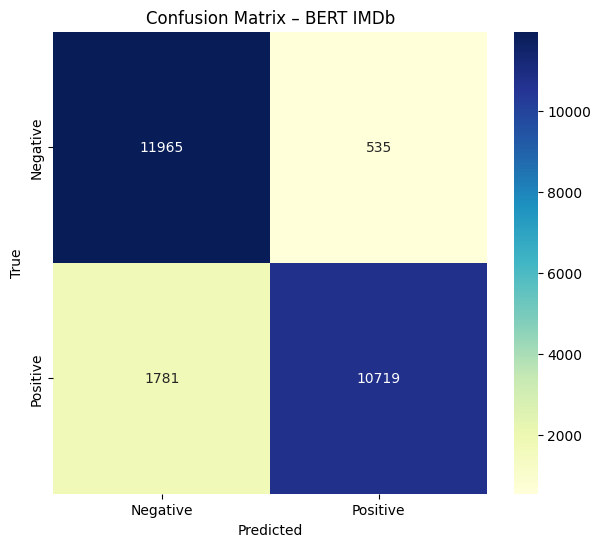

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

def plot_confusion_matrix_bert(trainer):
    """
    Plots the confusion matrix for BERT predictions on the test set.
    """
    preds = trainer.predict(trainer.eval_dataset)
    y_true = preds.label_ids
    y_pred = np.argmax(preds.predictions, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    labels = ["Negative", "Positive"]

    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix – BERT IMDb")
    plt.show()

plot_confusion_matrix_bert(trainer)


This cell visualizes the learning progress of the BERT sentiment classifier. Training and validation losses are plotted side by side across epochs to monitor convergence, detect overfitting, and evaluate model stability. Using a reusable function makes it easy to apply the same visualization to different experiments or models.

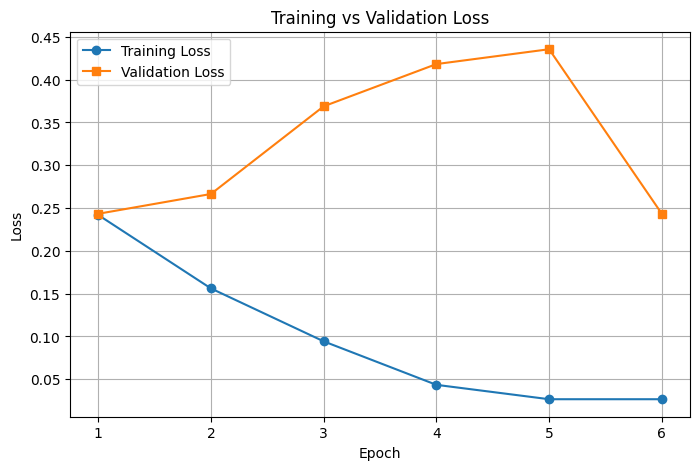

In [12]:
import matplotlib.pyplot as plt

def plot_loss_curves(trainer, title="Training vs Validation Loss"):
    """
    Plots training and validation loss curves from a HuggingFace Trainer object.

    Parameters:
    -----------
    trainer : transformers.Trainer
        The trained Trainer object containing log history.
    title : str
        Title of the plot.
    """
    train_losses = []
    eval_losses = []
    epochs = []

    current_epoch = 0
    last_train_loss = None

    for log in trainer.state.log_history:
        # Capture training loss if available
        if "loss" in log and "epoch" in log:
            last_train_loss = log["loss"]

        # Capture evaluation loss at the end of each epoch
        if "eval_loss" in log:
            current_epoch += 1
            epochs.append(current_epoch)
            eval_losses.append(log["eval_loss"])
            train_losses.append(last_train_loss)

    # Plot
    plt.figure(figsize=(8,5))
    plt.plot(epochs, train_losses, marker="o", label="Training Loss")
    plt.plot(epochs, eval_losses, marker="s", label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Function call
plot_loss_curves(trainer)


# This prepares a baseline model using Logistic Regression with TF-IDF features, providing a simple reference point before applying BERT for sentiment classification.

This cell implements the baseline text classification model using TF-IDF vectorization and Logistic Regression. The raw text data is transformed into numerical features using TF-IDF, which captures word importance across the corpus. A Logistic Regression classifier is then trained and evaluated on the test set. Key evaluation metrics such as accuracy, precision, recall, and F1-score are calculated to provide a baseline performance for comparison with the BERT model.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def train_evaluate_baseline(X_train, y_train, X_test, y_test, max_features=10000):
    """
    Trains a TF-IDF + Logistic Regression baseline model and evaluates it.

    Parameters
    ----------
    X_train : list or array-like
        Training text data.
    y_train : list or array-like
        Training labels.
    X_test : list or array-like
        Testing text data.
    y_test : list or array-like
        Testing labels.
    max_features : int
        Maximum number of TF-IDF features.

    Returns
    -------
    model : sklearn Pipeline
        Trained Logistic Regression model.
    metrics : dict
        Dictionary containing accuracy, precision, recall, and F1-score.
    """
    # Vectorize text using TF-IDF
    tfidf = TfidfVectorizer(max_features=max_features, stop_words="english")
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)

    # Train Logistic Regression
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_tfidf, y_train)

    # Predictions
    y_pred = model.predict(X_test_tfidf)

    # Evaluation
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted")

    metrics = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

    # Print results
    print("Baseline Logistic Regression Performance:")
    print(f"Accuracy :  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")

    return model, metrics, y_pred

# Function call
baseline_model, baseline_metrics, baseline_preds = train_evaluate_baseline(
    X_train=dataset["train"]["text"],
    y_train=dataset["train"]["label"],
    X_test=dataset["test"]["text"],
    y_test=dataset["test"]["label"]
)


Baseline Logistic Regression Performance:
Accuracy :  0.8804
Precision: 0.8804
Recall   : 0.8804
F1-score : 0.8804


A confusion matrix is computed and visualized to show how well the Logistic Regression baseline distinguishes between positive and negative reviews.

<Figure size 600x500 with 0 Axes>

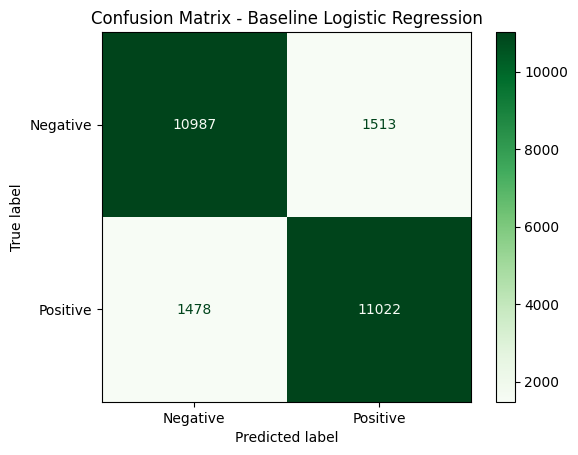

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_baseline_confusion_matrix(y_true, y_pred, class_names=["Negative", "Positive"], cmap="Greens"):
    """
    Plots a confusion matrix for the baseline Logistic Regression model.

    Parameters
    ----------
    y_true : array-like
        True class labels.
    y_pred : array-like
        Predicted class labels.
    class_names : list
        Names of the classes to display on axes.
    cmap : str
        Color map for heatmap visualization.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    plt.figure(figsize=(6, 5))
    disp.plot(cmap=cmap)
    plt.title("Confusion Matrix - Baseline Logistic Regression")
    plt.show()

# Function call
plot_baseline_confusion_matrix(
    y_true=dataset["test"]["label"],
    y_pred=baseline_preds,
    class_names=["Negative", "Positive"],
    cmap="Greens"
)


This cell compares the performance of the baseline Logistic Regression model and the fine-tuned BERT model across key metrics: Accuracy, Precision, Recall, and F1-score. The results are displayed in a structured DataFrame for easy interpretation and further analysis. This approach ensures reproducibility and clarity in presenting model performance.

In [16]:
import pandas as pd

def compare_model_performance(baseline_metrics_dict, bert_metrics):
    """
    Creates a comparison DataFrame of performance metrics for baseline and BERT models.

    Parameters
    ----------
    baseline_metrics_dict : dict
        Dictionary containing 'accuracy', 'precision', 'recall', 'f1_score' for baseline model.
    bert_metrics : dict
        Dictionary containing 'eval_accuracy', 'eval_precision', 'eval_recall', 'eval_f1' for BERT model.

    Returns
    -------
    pd.DataFrame
        DataFrame summarizing model performance.
    """
    comparison_results = {
        "Model": ["Logistic Regression", "Fine-tuned BERT"],
        "Accuracy": [baseline_metrics_dict["accuracy"], bert_metrics["eval_accuracy"]],
        "Precision": [baseline_metrics_dict["precision"], bert_metrics["eval_precision"]],
        "Recall": [baseline_metrics_dict["recall"], bert_metrics["eval_recall"]],
        "F1-score": [baseline_metrics_dict["f1_score"], bert_metrics["eval_f1"]]
    }
    return pd.DataFrame(comparison_results)

# BERT metrics already obtained from trainer.evaluate()
bert_metrics = trainer.evaluate()

# Generate comparison table, using the 'baseline_metrics' variable from the previous cell
comparison_df = compare_model_performance(baseline_metrics, bert_metrics)
comparison_df

,Model,Accuracy,Precision,Recall,F1-score
0,Logistic Regression,0.88036,0.880363,0.88036,0.880360
1,Fine-tuned BERT,0.90736,0.952461,0.85752,0.902501


This cell visualizes the comparison of performance metrics (Accuracy, Precision, Recall, F1-score) between the baseline Logistic Regression model and the fine-tuned BERT model. Each metric is represented by a separate bar for clear comparison. The visualization follows a consistent color scheme, includes gridlines, and shows scores in the range of interest to highlight differences. This helps in quickly understanding which model performs better on the IMDb dataset.

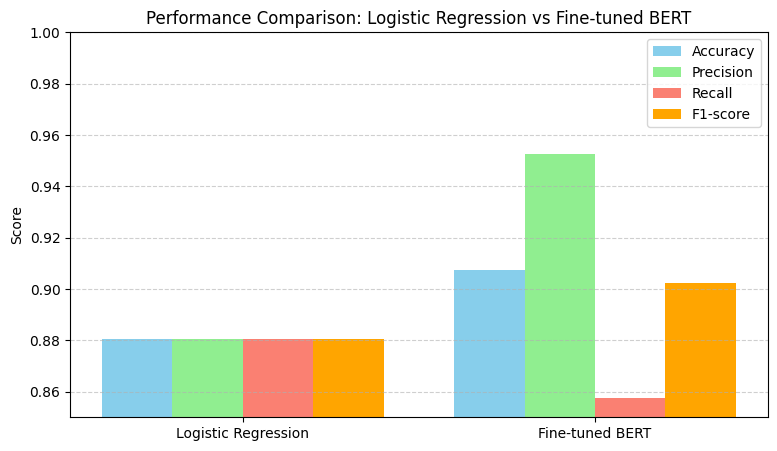

In [17]:
import matplotlib.pyplot as plt
import numpy as np


# Model Performance Metrics

models = ["Logistic Regression", "Fine-tuned BERT"]

# Use metrics from  latest evaluation
accuracy = [0.88036, 0.90736]
precision = [0.880363, 0.952461]
recall = [0.88036, 0.85752]
f1 = [0.880360, 0.902501]


# X positions for grouped bars
x = np.arange(len(models))
width = 0.2


# Plot

plt.figure(figsize=(9, 5))

plt.bar(x - 1.5*width, accuracy, width, label="Accuracy", color="skyblue")
plt.bar(x - 0.5*width, precision, width, label="Precision", color="lightgreen")
plt.bar(x + 0.5*width, recall, width, label="Recall", color="salmon")
plt.bar(x + 1.5*width, f1, width, label="F1-score", color="orange")

# Labels and title
plt.xticks(x, models)
plt.ylabel("Score")
plt.title("Performance Comparison: Logistic Regression vs Fine-tuned BERT")
plt.ylim(0.85, 1.0)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend()

# Display plot
plt.show()


A bar chart is created to visually compare the accuracy of the Logistic Regression baseline and the fine-tuned BERT model, highlighting the performance improvement with BERT.

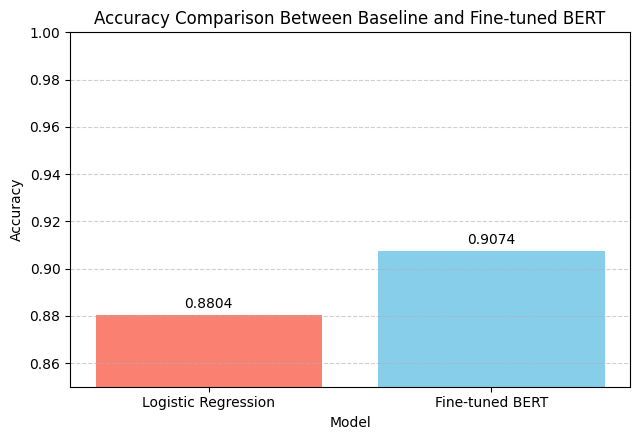

In [18]:
import matplotlib.pyplot as plt


# Models and Accuracy Metrics

models = ["Logistic Regression", "Fine-tuned BERT"]
accuracy = [0.88036, 0.90736]


# Create Figure

fig, ax = plt.subplots(figsize=(6.5, 4.5))

# Bar plot
bars = ax.bar(models, accuracy, color=['salmon', 'skyblue'])

# Labels, title, and limits
ax.set_ylabel("Accuracy")
ax.set_xlabel("Model")
ax.set_title("Accuracy Comparison Between Baseline and Fine-tuned BERT")
ax.set_ylim(0.85, 1.0)


# Add value labels on top of bars

for bar in bars:
    height = bar.get_height()
    ax.annotate(
        f"{height:.4f}",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),  # offset
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=10
    )

# Grid for easier reading
ax.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


# Extra Naïve Bayes Performance

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

y_pred_nb = nb.predict(X_test_tfidf)

nb_accuracy = accuracy_score(y_test, y_pred_nb)
nb_precision, nb_recall, nb_f1, _ = precision_recall_fscore_support(
    y_test, y_pred_nb, average="binary"
)

print("Naïve Bayes Performance:")
print(f"Accuracy:  {nb_accuracy:.4f}")
print(f"Precision: {nb_precision:.4f}")
print(f"Recall:    {nb_recall:.4f}")
print(f"F1-score:  {nb_f1:.4f}")


Naïve Bayes Performance:
Accuracy:  0.8342
Precision: 0.8605
Recall:    0.7977
F1-score:  0.8279
